In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import psycopg2
from pathlib import Path
from collections import Counter
# from config import password

In [3]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced

In [4]:
sentiments_data_to_load = "twitter.csv"
sentiments_df = pd.read_csv(sentiments_data_to_load, low_memory=False)
sentiments_df.head()

,comment_id,ticker,date,username,subreddit,body,overall_sent_comp,overall_sent_pos,overall_sent_neg,mean_t_comp_score,mean_t_pos_score,mean_t_neg_score,mean_tgt_comp_score,mean_tgt_pos_score,mean_tgt_neg_score,verb_tense,mean_custom_score
0,1007445,DIS,2020-08-11,Hubers57,wallstreetbets,Pretty uncommon to find a 100%+ iv stock like ...,0.5078,0.102,0.075,0.08706666666666667,0.11783333333333333,0.0485,-0.5818,0.084,0.157,present,0
1,1007451,MSFT,2020-08-11,duathman,wallstreetbets,Haha. If we keep swinging down it will wipe m...,-0.4215,0.167,0.203,0.009333333333333324,0.42,0.10533333333333333,-0.8126,0.082,0.316,future,-1
2,1007456,TA,2020-08-10,sc0tt_1990,wallstreetbets,Here''s what will happen: NCAA is rallying the...,0.9231,0.154,0,0.18462,0.059,0,0.9231,0.295,0,present,-1
3,1007469,TSLA,2020-08-10,smallstreetgains,wallstreetbets,**Subreddit:** /r/wallstreetbets\n\n**Searched...,0.1779,0.022,0.013,0.03119999999999999,0.006,0.08775,0.5267,0.024,0,present,0.14285714285714285
4,1007469,AAPL,2020-08-10,smallstreetgains,wallstreetbets,**Subreddit:** /r/wallstreetbets\n\n**Searched...,0.1779,0.022,0.013,0.03119999999999999,0.006,0.08775,0.5267,0.024,0,present,0.14285714285714285


In [5]:
sentiments_df['ticker'].value_counts()

BA                                                                                                                                                                                                                        24339
SPCE                                                                                                                                                                                                                      23462
RE                                                                                                                                                                                                                        16773
TIL                                                                                                                                                                                                                       14092
MSFT                                                                                                    

In [6]:
# ticker_list = ["BA","SPCE","TIL","MSFT","AMD","AAPL","AMZN","FB","DIS","NVDA","NFLX","GOOG","TSLA","SQ","BABA","TD","AI","TA"]
ticker_list = ["MSFT","AAPL","AMZN","FB","GOOG"]

In [7]:
cleaned_sentiments_df = sentiments_df.loc[sentiments_df["ticker"].isin (ticker_list)]

cleaned_sentiments_df.head()

,comment_id,ticker,date,username,subreddit,body,overall_sent_comp,overall_sent_pos,overall_sent_neg,mean_t_comp_score,mean_t_pos_score,mean_t_neg_score,mean_tgt_comp_score,mean_tgt_pos_score,mean_tgt_neg_score,verb_tense,mean_custom_score
1,1007451,MSFT,2020-08-11,duathman,wallstreetbets,Haha. If we keep swinging down it will wipe m...,-0.4215,0.167,0.203,0.009333333333333324,0.42,0.10533333333333333,-0.8126,0.082,0.316,future,-1
4,1007469,AAPL,2020-08-10,smallstreetgains,wallstreetbets,**Subreddit:** /r/wallstreetbets\n\n**Searched...,0.1779,0.022,0.013,0.03119999999999999,0.006,0.08775,0.5267,0.024,0,present,0.14285714285714285
6,1007469,MSFT,2020-08-10,smallstreetgains,wallstreetbets,**Subreddit:** /r/wallstreetbets\n\n**Searched...,0.1779,0.022,0.013,0.03119999999999999,0.006,0.08775,0.5267,0.024,0,present,0.14285714285714285
7,1007469,FB,2020-08-10,smallstreetgains,wallstreetbets,**Subreddit:** /r/wallstreetbets\n\n**Searched...,0.1779,0.022,0.013,0.03119999999999999,0.006,0.08775,0.5267,0.024,0,present,0.14285714285714285
12,1007492,AMZN,2020-08-10,captain_blabbin,wallstreetbets,Just grabbed a couple FB Jan 15 ''21 280c''s ....,-0.6872,0.043,0.124,-0.3436,0.045,0.1295,-0.6872,0.09,0.259,present,1


In [8]:
cleaned_sentiments_df.shape

(21256, 17)

In [9]:
final_sentiments_df = cleaned_sentiments_df.drop(columns=["comment_id","date","username","subreddit","body","verb_tense"])

final_sentiments_df.shape

(21256, 11)

In [10]:
final_sentiments_df.to_csv("final_twitter.csv")

In [11]:
X = final_sentiments_df.drop(columns=["mean_custom_score"])
X.shape

(21256, 10)

In [12]:
y = final_sentiments_df.loc[:, ["mean_custom_score"]].copy()
y.shape

(21256, 1)

In [13]:
# Check the balance of our target values
X['ticker'].value_counts()

MSFT    4957
AAPL    4611
AMZN    4186
FB      4063
GOOG    3439
Name: ticker, dtype: int64

In [14]:
from sklearn import preprocessing

def encode_feature(array):
    """ Encode a categorical array into a number array
    
    :param array: array to be encoded
    :return: numerical array
    """
  
    encoder = preprocessing.LabelEncoder()
    encoder.fit(array)
    return encoder.transform(array)

In [15]:
X["ticker"] = encode_feature(X["ticker"])

In [16]:
X['ticker'].value_counts()

# MSFT    4
# AAPL    0
# AMZN    1
# FB      2
# GOOG    3

4    4957
0    4611
1    4186
2    4063
3    3439
Name: ticker, dtype: int64

In [17]:
X.head()

,ticker,overall_sent_comp,overall_sent_pos,overall_sent_neg,mean_t_comp_score,mean_t_pos_score,mean_t_neg_score,mean_tgt_comp_score,mean_tgt_pos_score,mean_tgt_neg_score
1,4,-0.4215,0.167,0.203,0.009333333333333324,0.42,0.10533333333333333,-0.8126,0.082,0.316
4,0,0.1779,0.022,0.013,0.03119999999999999,0.006,0.08775,0.5267,0.024,0
6,4,0.1779,0.022,0.013,0.03119999999999999,0.006,0.08775,0.5267,0.024,0
7,2,0.1779,0.022,0.013,0.03119999999999999,0.006,0.08775,0.5267,0.024,0
12,1,-0.6872,0.043,0.124,-0.3436,0.045,0.1295,-0.6872,0.09,0.259


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [19]:
# Resample the training data with the RandomOversampler
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
Counter(y_resampled)

Counter({'mean_custom_score': 1})

In [20]:
# Train the Logistic Regression model using the resampled data
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [21]:
# Calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score
y_pred = model.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.3625643157469876

In [22]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[   1,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0],
       [   1,    0,    0,    0,    0,    0,    0,    1,    0,    0,    0,
           0,    2,    0,    0,    3,    1,    0,    0,    0,    0,    1,
           0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0],
       [   0,    4,    1,    0,    0,    1,    1,    3,    3,    0,    3,
           0,    0,    1,    3,    0,    1,    0,    0,    0,    0,    0,
           1,    3,    1,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    

In [23]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test, y_pred))

                            pre       rec       spe        f1       geo       iba       sup

-0.14285714285714285       0.04      1.00      1.00      0.08      1.00      1.00         1
-0.16666666666666666       0.00      0.00      0.99      0.00      0.00      0.00         0
                -0.2       0.00      0.00      0.98      0.00      0.00      0.00         9
               -0.25       0.00      0.00      1.00      0.00      0.00      0.00         0
 -0.3333333333333333       0.00      0.00      0.98      0.00      0.00      0.00        26
-0.33333333333333337       0.00      0.00      1.00      0.00      0.00      0.00         0
-0.42857142857142855       0.00      0.00      0.99      0.00      0.00      0.00         0
                -0.5       0.00      0.00      0.99      0.00      0.00      0.00         3
                -0.6       0.00      0.00      0.97      0.00      0.00      0.00         1
 -0.6666666666666666       0.10      1.00      1.00      0.18      1.00      1.

In [24]:
# Resample the training data with SMOTE
from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE(random_state=1, sampling_strategy='auto').fit_resample(X_train, y_train)
from collections import Counter
Counter(y_resampled)

ValueError: Expected n_neighbors <= n_samples,  but n_samples = 3, n_neighbors = 6

In [25]:
# Train the Logistic Regression model using the resampled data
model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [26]:
# Calculated the balanced accuracy score
y_pred = model.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.3625643157469876

In [27]:
# Display the confusion matrix
confusion_matrix(y_test, y_pred)

array([[   1,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0],
       [   1,    0,    0,    0,    0,    0,    0,    1,    0,    0,    0,
           0,    2,    0,    0,    3,    1,    0,    0,    0,    0,    1,
           0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0],
       [   0,    4,    1,    0,    0,    1,    1,    3,    3,    0,    3,
           0,    0,    1,    3,    0,    1,    0,    0,    0,    0,    0,
           1,    3,    1,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    

In [28]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                            pre       rec       spe        f1       geo       iba       sup

-0.14285714285714285       0.04      1.00      1.00      0.08      1.00      1.00         1
-0.16666666666666666       0.00      0.00      0.99      0.00      0.00      0.00         0
                -0.2       0.00      0.00      0.98      0.00      0.00      0.00         9
               -0.25       0.00      0.00      1.00      0.00      0.00      0.00         0
 -0.3333333333333333       0.00      0.00      0.98      0.00      0.00      0.00        26
-0.33333333333333337       0.00      0.00      1.00      0.00      0.00      0.00         0
-0.42857142857142855       0.00      0.00      0.99      0.00      0.00      0.00         0
                -0.5       0.00      0.00      0.99      0.00      0.00      0.00         3
                -0.6       0.00      0.00      0.97      0.00      0.00      0.00         1
 -0.6666666666666666       0.10      1.00      1.00      0.18      1.00      1.

In [29]:
# Resample the data using the ClusterCentroids resampler
# Warning: This is a large dataset, and this step may take some time to complete
from imblearn.under_sampling import ClusterCentroids
cc = ClusterCentroids(random_state=1)
X_resampled, y_resampled = cc.fit_resample(X_train, y_train)
from collections import Counter
Counter(y_resampled)

Counter({'mean_custom_score': 1})

In [30]:
# Train the Logistic Regression model using the resampled data
model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [31]:
# Calculated the balanced accuracy score
y_pred = model.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.062388591800356503

In [32]:
# Display the confusion matrix
confusion_matrix(y_test, y_pred)

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    1,    0,    0,
           0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0],
       [   0,    0,    0,    2,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    4,    2,    1,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0],
       [   0,    0,    0,    1,    0,    4,    8,    0,    0,    0,    0,
           0,    0,    1,    0,    0,    0,    0,    0,    0,    1,    0,
           0,    3,    7,    1,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    

In [33]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                            pre       rec       spe        f1       geo       iba       sup

-0.14285714285714285       0.00      0.00      1.00      0.00      0.00      0.00         1
-0.16666666666666666       0.00      0.00      1.00      0.00      0.00      0.00         0
                -0.2       0.00      0.00      1.00      0.00      0.00      0.00         9
               -0.25       0.00      0.00      0.89      0.00      0.00      0.00         0
 -0.3333333333333333       0.00      0.00      1.00      0.00      0.00      0.00        26
-0.33333333333333337       0.00      0.00      0.97      0.00      0.00      0.00         0
-0.42857142857142855       0.00      0.00      0.97      0.00      0.00      0.00         0
                -0.5       0.00      0.00      1.00      0.00      0.00      0.00         3
                -0.6       0.00      0.00      1.00      0.00      0.00      0.00         1
 -0.6666666666666666       0.00      0.00      1.00      0.00      0.00      0.

In [34]:
# Resample the training data with SMOTEENN
# Warning: This is a large dataset, and this step may take some time to complete
from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=1)
X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)
from collections import Counter
Counter(y_resampled)

ValueError: Expected n_neighbors <= n_samples,  but n_samples = 3, n_neighbors = 6

In [35]:
# Train the Logistic Regression model using the resampled data
model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [36]:
# Calculated the balanced accuracy score
y_pred = model.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.062388591800356503

In [37]:
# Display the confusion matrix
confusion_matrix(y_test, y_pred)

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    1,    0,    0,
           0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0],
       [   0,    0,    0,    2,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    4,    2,    1,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0],
       [   0,    0,    0,    1,    0,    4,    8,    0,    0,    0,    0,
           0,    0,    1,    0,    0,    0,    0,    0,    0,    1,    0,
           0,    3,    7,    1,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    

In [38]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                            pre       rec       spe        f1       geo       iba       sup

-0.14285714285714285       0.00      0.00      1.00      0.00      0.00      0.00         1
-0.16666666666666666       0.00      0.00      1.00      0.00      0.00      0.00         0
                -0.2       0.00      0.00      1.00      0.00      0.00      0.00         9
               -0.25       0.00      0.00      0.89      0.00      0.00      0.00         0
 -0.3333333333333333       0.00      0.00      1.00      0.00      0.00      0.00        26
-0.33333333333333337       0.00      0.00      0.97      0.00      0.00      0.00         0
-0.42857142857142855       0.00      0.00      0.97      0.00      0.00      0.00         0
                -0.5       0.00      0.00      1.00      0.00      0.00      0.00         3
                -0.6       0.00      0.00      1.00      0.00      0.00      0.00         1
 -0.6666666666666666       0.00      0.00      1.00      0.00      0.00      0.

In [39]:
# Resample the training data with the BalancedRandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
brf = BalancedRandomForestClassifier(n_estimators=100, random_state=1)
brf.fit(X_train, y_train)

BalancedRandomForestClassifier(random_state=1)

In [40]:
# Calculated the balanced accuracy score
y_pred = brf.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.4422128553266853

In [41]:
# Display the confusion matrix
confusion_matrix(y_test, y_pred)

array([[   1,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0],
       [   0,    0,    2,    1,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    1,    3,    0,    0,    0,    0,    1,    0,
           0,    0,    1,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0],
       [   0,    5,    0,    2,    1,    1,    2,    0,    6,    0,    0,
           0,    0,    2,    1,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    6,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    

In [42]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                            pre       rec       spe        f1       geo       iba       sup

-0.14285714285714285       0.17      1.00      1.00      0.29      1.00      1.00         1
-0.16666666666666666       0.00      0.00      0.98      0.00      0.00      0.00         0
                -0.2       0.00      0.22      0.91      0.01      0.45      0.19         9
               -0.25       0.00      0.00      0.99      0.00      0.00      0.00         0
 -0.3333333333333333       0.04      0.04      1.00      0.04      0.20      0.03        26
-0.33333333333333337       0.00      0.00      0.99      0.00      0.00      0.00         0
-0.42857142857142855       0.00      0.00      0.97      0.00      0.00      0.00         0
                -0.5       0.00      0.00      1.00      0.00      0.00      0.00         3
                -0.6       0.00      1.00      0.95      0.01      0.97      0.95         1
 -0.6666666666666666       0.17      1.00      1.00      0.29      1.00      1.

In [43]:
# List the features sorted in descending order by feature importance
importances = brf.feature_importances_
cols = X.columns
feature_importances_df = pd.DataFrame({'feature':cols, 'importance': importances})
feature_importances_df.head()
feature_importances_df.sort_values('importance', ascending=False)

,feature,importance
6,mean_t_neg_score,0.120976
7,mean_tgt_comp_score,0.119459
5,mean_t_pos_score,0.115862
1,overall_sent_comp,0.110528
8,mean_tgt_pos_score,0.109769
2,overall_sent_pos,0.107346
3,overall_sent_neg,0.099340
4,mean_t_comp_score,0.084648
9,mean_tgt_neg_score,0.077475
0,ticker,0.054596


In [44]:
# Train the EasyEnsembleClassifier
from imblearn.ensemble import EasyEnsembleClassifier
eec = EasyEnsembleClassifier(n_estimators=100, random_state=1)
eec.fit(X_train, y_train)

EasyEnsembleClassifier(n_estimators=100, random_state=1)

In [45]:
# Calculated the balanced accuracy score
y_pred = eec.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.29282663809750864

In [46]:
# Display the confusion matrix
confusion_matrix(y_test, y_pred)

array([[   1,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0],
       [   0,    1,    0,    3,    0,    0,    0,    0,    0,    0,    0,
           0,    2,    0,    0,    3,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0],
       [   0,    6,    0,    6,    0,    1,    3,    1,    1,    0,    0,
           0,    0,    1,    0,    0,    0,    0,    0,    4,    0,    0,
           0,    0,    3,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    

In [47]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                            pre       rec       spe        f1       geo       iba       sup

-0.14285714285714285       0.14      1.00      1.00      0.25      1.00      1.00         1
-0.16666666666666666       0.00      0.00      0.95      0.00      0.00      0.00         0
                -0.2       0.00      0.00      1.00      0.00      0.00      0.00         9
               -0.25       0.00      0.00      0.95      0.00      0.00      0.00         0
 -0.3333333333333333       0.00      0.00      1.00      0.00      0.00      0.00        26
-0.33333333333333337       0.00      0.00      1.00      0.00      0.00      0.00         0
-0.42857142857142855       0.00      0.00      0.99      0.00      0.00      0.00         0
                -0.5       0.00      0.00      0.99      0.00      0.00      0.00         3
                -0.6       0.00      0.00      0.97      0.00      0.00      0.00         1
 -0.6666666666666666       0.00      0.00      1.00      0.00      0.00      0.

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder

In [49]:
# Look at APPLICATION_TYPE value counts for binning
comment_counts = sentiments_df["body"].value_counts()
print(len(comment_counts))
comment_counts

74380


Well these are the stocks i like and in this specific order, unless it''s a Monday following a 4-day trading week, if the 12th of the month falls on a Thursday or it''s after-hours market in which case you reverse all the ticker symbols and then those are the stocks I like:\n\nMGM, MCHP, MU, MSFT, SWKS, SLG, SNA, SO, LUV, SWK, SBUX, STT, STE, SYK, SIVB, SYF, SNPS, SYY, TMUS, TROW, TTWO, TPR, TGT, TEL, FTI, TFX, TXN, TXT, TMO, TIF, TJX, TSCO, TDG, TRV, TFC, TWTR, TSN, UDR, ULTA, USB, UAA, UA, UNP, UAL, UNH, UPS, URI, UTX, UHS, UNM, VFC, VLO, VAR, VTR, VRSN, VRSK, VZ, VRTX, VIAC, V, VNO, VMC, WRB, WAB, WMT, WBA, DIS, WM, WAT, WEC, WFC, WELL, WDC, WU, WRK, WY, WHR, WMB, WLTW, WYNN, XEL, XRX, XLNX, XYL, YUM, ZBRA, ZBH, ZION, ZTS MMM, ABT, ABBV, ABMD,  AVY, BKR, BLL, BAC, BK, BAX, BDX, BRK.B, BBY, BIIB, BLK, BA, BKNG, BWA, BXP, BSX, BMY, AVGO, BR, BF.B, CHRW, COG, CDNS, CPB, COF, CPRI, CAH, KMX, CCL, CAT, CBOE, CBRE, CDW, CE, CNC, CNP, CTL, CERN, CF, SCHW, CHTR, CVX, CMG, CB, CHD, CI, XEC, 

<AxesSubplot:ylabel='Density'>

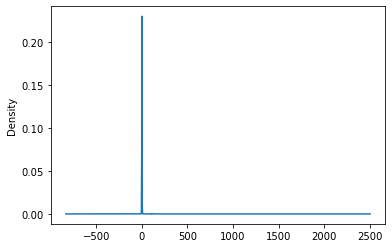

In [50]:
# Visualize the value counts of comments
comment_counts.plot.density()

In [52]:
# Determine which values to replace if counts are less than ...?
#replace_application = list(application_counts[application_counts < 500].index)

# Replace in dataframe
#for app in replace_application:
    #application_df.APPLICATION_TYPE = application_df.APPLICATION_TYPE.replace(app,"Other")
    
# Check to make sure binning was successful
sentiments_df.body.value_counts()

Well these are the stocks i like and in this specific order, unless it''s a Monday following a 4-day trading week, if the 12th of the month falls on a Thursday or it''s after-hours market in which case you reverse all the ticker symbols and then those are the stocks I like:\n\nMGM, MCHP, MU, MSFT, SWKS, SLG, SNA, SO, LUV, SWK, SBUX, STT, STE, SYK, SIVB, SYF, SNPS, SYY, TMUS, TROW, TTWO, TPR, TGT, TEL, FTI, TFX, TXN, TXT, TMO, TIF, TJX, TSCO, TDG, TRV, TFC, TWTR, TSN, UDR, ULTA, USB, UAA, UA, UNP, UAL, UNH, UPS, URI, UTX, UHS, UNM, VFC, VLO, VAR, VTR, VRSN, VRSK, VZ, VRTX, VIAC, V, VNO, VMC, WRB, WAB, WMT, WBA, DIS, WM, WAT, WEC, WFC, WELL, WDC, WU, WRK, WY, WHR, WMB, WLTW, WYNN, XEL, XRX, XLNX, XYL, YUM, ZBRA, ZBH, ZION, ZTS MMM, ABT, ABBV, ABMD,  AVY, BKR, BLL, BAC, BK, BAX, BDX, BRK.B, BBY, BIIB, BLK, BA, BKNG, BWA, BXP, BSX, BMY, AVGO, BR, BF.B, CHRW, COG, CDNS, CPB, COF, CPRI, CAH, KMX, CCL, CAT, CBOE, CBRE, CDW, CE, CNC, CNP, CTL, CERN, CF, SCHW, CHTR, CVX, CMG, CB, CHD, CI, XEC, 

In [53]:
# Look at CLASSIFICATION value counts for binning
class_counts = sentiments_df.CLASSIFICATION.value_counts()
class_counts

AttributeError: 'DataFrame' object has no attribute 'CLASSIFICATION'

In [54]:
# Visualize the value counts of CLASSIFICATION
class_counts.plot.density()

NameError: name 'class_counts' is not defined

In [56]:
# Generate our categorical variable lists
comments_cat = sentiments_df.dtypes[sentiments_df.dtypes == "object"].index.tolist()
comments_cat

['comment_id',
 'ticker',
 'date',
 'username',
 'subreddit',
 'body',
 'overall_sent_comp',
 'overall_sent_pos',
 'overall_sent_neg',
 'mean_t_comp_score',
 'mean_t_pos_score',
 'mean_t_neg_score',
 'mean_tgt_comp_score',
 'mean_tgt_pos_score',
 'mean_tgt_neg_score',
 'verb_tense',
 'mean_custom_score']

In [57]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(sentiments_df[comments_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(sentiments_cat)
encode_df.head()

MemoryError: Unable to allocate 160. GiB for an array with shape (125485, 171624) and data type float64

In [58]:
# Merge one-hot encoded features and drop the originals
sentiments_df = sentiments_df.merge(encode_df,left_index=True, right_index=True)
sentiments_df = sentiments_df.drop(comments_cat,1)
comments_df.head()

NameError: name 'encode_df' is not defined

In [ ]:
# Split our preprocessed data into our features and target arrays
y = comments_df["Positive"].values
X = comments_df.drop(["Negative"],1).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [ ]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train[0])
hidden_nodes_layer1 =  80
hidden_nodes_layer2 = 30
nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

In [ ]:
# Import checkpoint dependencies
import os
from tensorflow.keras.callbacks import ModelCheckpoint
# Define the checkpoint path and filenames
os.makedirs("checkpoints/",exist_ok=True)
checkpoint_path = "checkpoints/weights.{epoch:02d}.hdf5"

In [ ]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
# Create a callback that saves the model's weights every 5 epochs
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=1000)

In [ ]:
# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=100, callbacks=[cp_callback])

In [ ]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")